# Image processing pipeline - tuned on library
First import the packages to set up

In [2]:
# Import necessary packages
#%pip install imutils opencv-python simplekml palettable gdown
import helper_functions as hf
import plotting as pl
import stitching as st
import gdown
import os
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
import cv2
import imageio
import imutils
from palettable import colorbrewer
from scipy import ndimage
from collections import Counter
from itertools import compress
cv2.ocl.setUseOpenCL(False)

  Using cached imutils-0.5.4-py3-none-any.whl
  Using cached opencv_python-4.5.3.56-cp37-cp37m-manylinux2014_x86_64.whl (49.9 MB)
  Using cached simplekml-1.3.5-py3-none-any.whl (65 kB)
  Using cached palettable-3.3.0-py2.py3-none-any.whl (111 kB)
  Using cached gdown-3.13.0-py3-none-any.whl
  Using cached filelock-3.0.12-py3-none-any.whl (7.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Variables
gdrive = False # Download data from google drive
link = 'https://drive.google.com/file/d/1IUIAgR7p-RBC8_UzkbhMlKweXaQEek8x/view?usp=sharing'
#'https://drive.google.com/file/d/1ANJ_Hq3C42Zfka_wIDX7wgbH_hwcUbGn/view?usp=sharing' # gdrive link
imgDir = 'data/lsm/Flight 1 - Library/thermal-data/' # Local directory to images
imageType, cmap = False, colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap # True if RGB images, False if numpy arrays. Choose matplotlib cmap for thermal
pathFile = 'data/lsm/Flight 1.csv' # Flight path .csv file
outName = 'library'
utcDiff = -1 # Time difference to UTC (-1 for BST)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)','speed(mps)'] # Columns used from the path file
filters = ['altitude(m)', 'timestamp', 'speed(mps)'] # Altitude criteria for using imagery
filtValues = [[119.7, 120.3], [1619811011923,1619811099149], [4.85,5.15]]
utmZone, hemisphere = '31n', 'north' # Specify UTM coordinate zone
resolution = 6 # Other resolution for plots
useCentre = True # True if only using center of images
skip = 20 # Plot every nth image for path
height = 120 # Height of camera
fov, pixels = 69, 640 # Long axis field of view and number of pixels of camera
pxSize = (height*np.tan(np.deg2rad(fov/2)))/(pixels/2) # Specify pixel size (m) - for now

In [4]:
# Download from google drive if gdrive is True
#%capture
if gdrive: 
    zippath = imgDir[:-1]+'.zip'
    downLink = link.split('/d/')[1].split('/view')[0]
    ! gdown -O $zippath 'https://drive.google.com/uc?export=download&id='$downLink
    ! unzip $zippath -d $imgDir
    ! rm $zippath

## 1 - Filter images and present sample

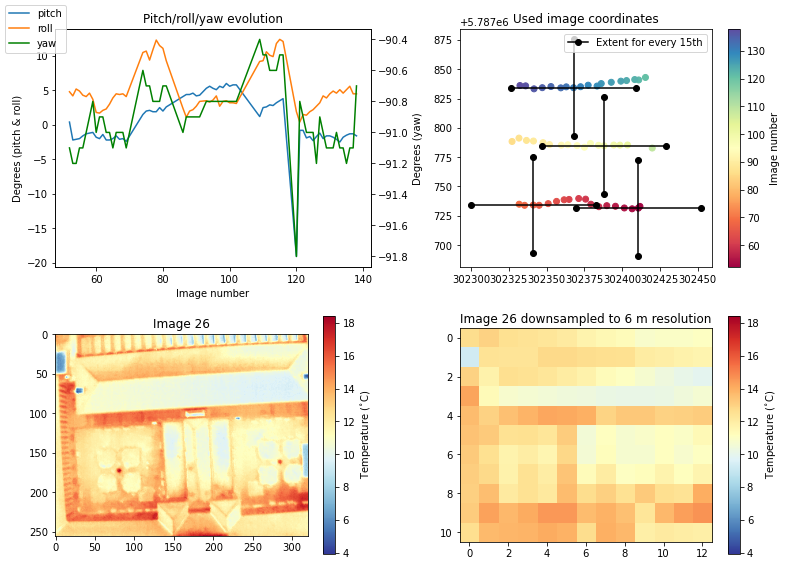

In [5]:
# Create dataframe of images associated with flight information
merged = hf.img_info_merge(imgDir, pathFile, utcDiff, pathColumns, imageType)
merged = hf.filter_imgs(merged, filters, filtValues)
merged, myProj = hf.reproject_coords(merged, utmZone, hemisphere)
idf = hf.correct_coords(merged, 20)

# Plot summary of flight and example image
fig, axs = plt.subplots(2,2,figsize=[11,8])
fig, axs[0,0] = pl.plot_orientation(fig, axs[0,0], merged) 
xq, yq, xCoords, yCoords = hf.use_centre(useCentre, idf, pxSize)
fig, axs[0,1] = pl.plot_route(fig, axs[0,1], idf, xq, yq, pxSize)
fig, axs[1,0] = pl.plot_image(fig, axs[1,0], idf, xq, yq, pxSize, pxSize, cmap, imageType=imageType)
fig, axs[1,1] = pl.plot_image(fig, axs[1,1], idf, xq, yq, pxSize, resolution, cmap, imageType=imageType)
fig.tight_layout()
plt.show()

## 2 - Merge according to xy coordinates

Images processed: 53it [00:02, 19.78it/s]


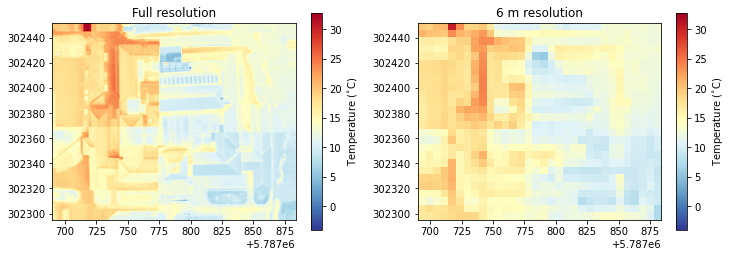

In [6]:
# Stitch images based on xy coordinates
xygrid, extent = st.img_xymerge(idf, xCoords, yCoords, xq, yq, pxSize, imageType=imageType)

# Plot output and downsample
fig, axs = plt.subplots(1,2,figsize=[12,4])
fig, axs[0] = pl.plot_array(fig, axs[0], xygrid, extent, cmap=cmap, title='Full resolution', imageType=imageType)
fig, axs[1] = pl.plot_array(fig, axs[1], hf.downsample_arr(xygrid,pxSize,resolution), extent, cmap=cmap, title=str(resolution)+' m resolution', imageType=imageType, scale=xygrid)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


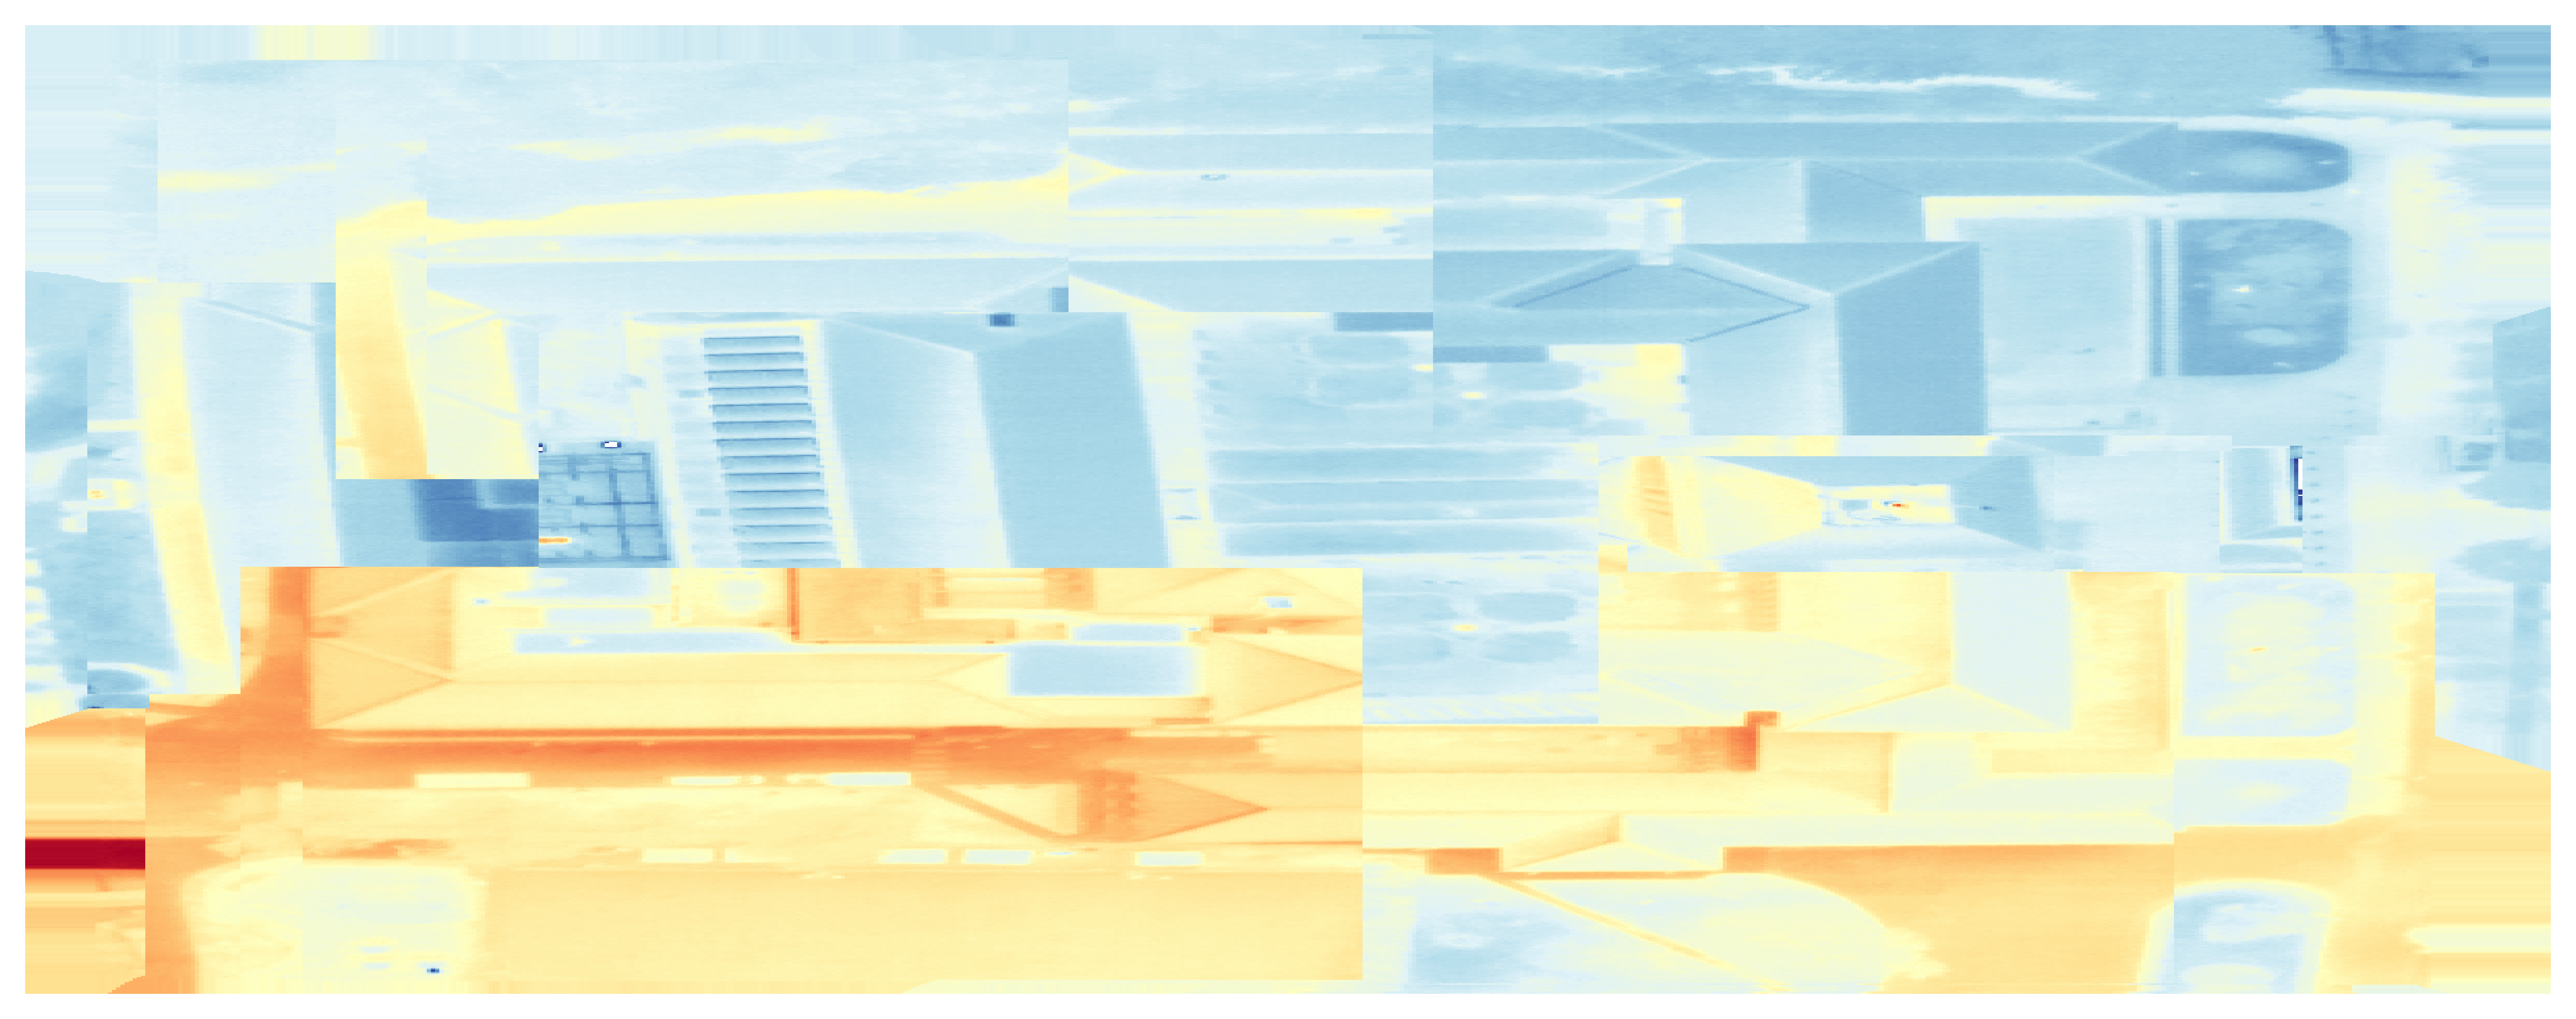

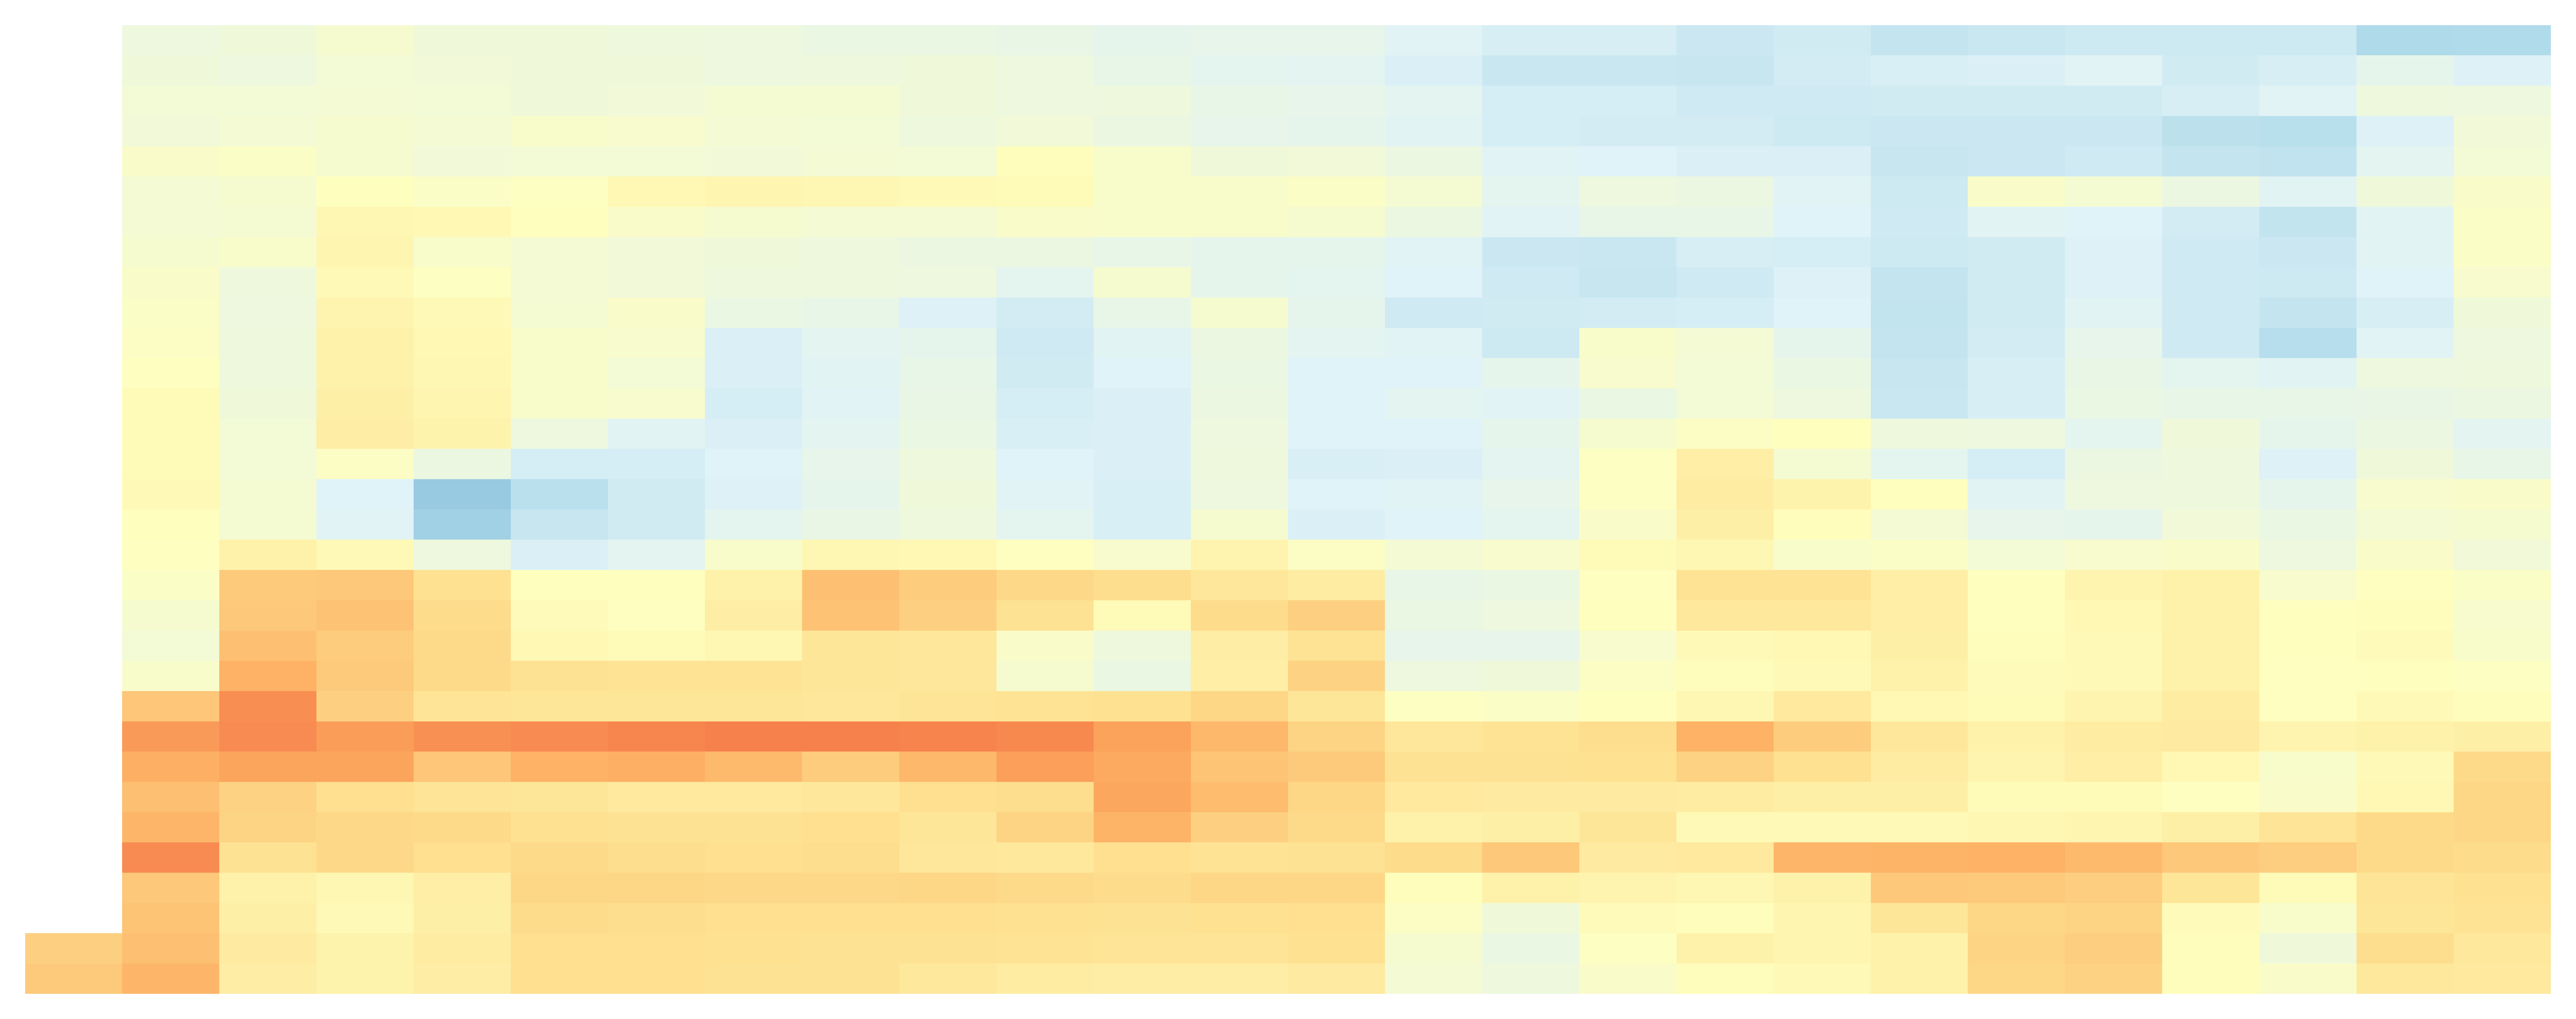

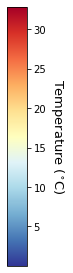

In [10]:
# Save as .kmz file
inputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, single = pl.plot_kml(xygrid, conv, outName+'_xymerge', 1024*10, rot=90)
_, ds = pl.plot_kml(hf.downsample_arr(xygrid,pxSize,resolution), conv, outName+'_ds_xymerge', 1024*10, rot=90, scale=xygrid)
pl.plot_kml_legend(cs, outName+'_xylegend')
pl.plot_kml_path(idf, conv, outName+'_xypath', 1024*10)
pl.make_kml(conv, figs=[outName+'_xymerge.png', outName+'_ds_xymerge.png', outName+'_xypath.png'], 
            colorbar=outName+'_xylegend.png', kmzfile=outName+'xymerge_thermal.kmz',
            description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')    

In [20]:
pl.save_to_csv(ds, single, conv, pxSize, resolution, outName+'_xymerge')

## 3 - Stitch using RANSAC algorithm
Stitch each flight line into individual strip

In [17]:
# Multi-image stitching
# Setup variables
tempfiles = ['temp0.jpg','temp1.jpg']
start, end, step = 0, len(idf), 1
tmin, tmax = -10, 40
lineDist = 10
imgPath='imgPath'
skips=[]

strips = {}
# Loop over all images
while start < end-1:

    prev, single, prevImg, totalBox, prevBox = initialise_vars(idf, start, xq, yq, tmin, tmax, path=imgPath)
    
    # Loop over images until break in continuous line
    for imgNum in tqdm(np.arange(start+step if start < end else start-step, end, step if start < end else -step)):
        if (np.hypot(abs(idf.iloc[imgNum]['xc']-idf.iloc[imgNum-1]['xc']),abs(idf.iloc[imgNum]['yc']-idf.iloc[imgNum-1]['yc']))) > lineDist:
            break
        if imgNum in skips: continue # Skip iteration if img in skips
        arrs = [hf.img_to_arr(idf.iloc[i][imgPath], xq=xq, yq=yq) for i in [prev, imgNum]]

        for i, val in enumerate(tempfiles): 
            single = ((arrs[i]-tmin)*255/tmax).astype(np.uint8)
            imageio.imwrite(val,np.dstack((single,single,single)))
        # Read images - Make sure that the train image is the image that will be transformed
        trainImg, queryImg = [imageio.imread(i) for i in tempfiles]

        ma, mb, _ = get_img_translation(trainImg, queryImg)

        mam, mbm, diff = filter_img_translation(ma, mb, idf, prev, imgNum)

        totalBox, prevNew, prevImg, prevBox = stitch_img_result(mam, mbm, diff, totalBox, prevBox, arrs, prevImg,
                                                                prev, imgNum, max_stdev=30, verbose=True)
        
        if prevNew < imgNum-3:
            imgNum = prevNew+1
            break
        else: prev=prevNew
        
    if start<imgNum-1: strips.update({start:prevImg})
    start = imgNum

ks = np.array(list(strips.keys()))
mn = strips[ks[0]].mean() # Get mean from first for scaling
for i in ks:
    read = ((strips[i]-strips[i].mean()+mn)*np.ma.masked_where(strips[i]!=0, strips[i]).mask).astype(np.uint8) # Rescale while keeping 0 values
    imageio.imwrite(outName+'strip'+str(i)+'.jpg',np.dstack((read[:,:,0],read[:,:,1],read[:,:,2])))
    
for i in tempfiles: os.remove(i)

  8%|▊         | 4/52 [00:00<00:01, 33.44it/s]

Raw matches (Brute force): 12
Filt. matches: 0, stdev: nan
Images 0 and 1, poor matching
Raw matches (Brute force): 8
Filt. matches: 8, stdev: 1.25
Images 0 and 2 merged.
Raw matches (Brute force): 28
Filt. matches: 28, stdev: 7.95
Images 2 and 3 merged.
Raw matches (Brute force): 29
Filt. matches: 29, stdev: 0.89
Images 3 and 4 merged.
Raw matches (Brute force): 19
Filt. matches: 19, stdev: 1.19
Images 4 and 5 merged.
Raw matches (Brute force): 18
Filt. matches: 18, stdev: 2.02
Images 5 and 6 merged.
Raw matches (Brute force): 13
Filt. matches: 13, stdev: 1.94
Images 6 and 7 merged.
Raw matches (Brute force): 18
Filt. matches: 17, stdev: 27.65
Images 7 and 8 merged.
Raw matches (Brute force): 25
Filt. matches: 24, stdev: 1.07


 33%|███▎      | 17/52 [00:00<00:00, 39.17it/s]

Images 8 and 9 merged.
Raw matches (Brute force): 29
Filt. matches: 29, stdev: 1.19
Images 9 and 10 merged.
Raw matches (Brute force): 25
Filt. matches: 24, stdev: 1.2
Images 10 and 11 merged.
Raw matches (Brute force): 30
Filt. matches: 30, stdev: 1.82
Images 11 and 12 merged.
Raw matches (Brute force): 27
Filt. matches: 27, stdev: 1.18
Images 12 and 13 merged.
Raw matches (Brute force): 21
Filt. matches: 21, stdev: 1.39
Images 13 and 14 merged.
Raw matches (Brute force): 15
Filt. matches: 13, stdev: 9.34
Images 14 and 15 merged.
Raw matches (Brute force): 15
Filt. matches: 14, stdev: 22.14
Images 15 and 16 merged.
Raw matches (Brute force): 6
Filt. matches: 1, stdev: 0.0
Images 16 and 17, poor matching



 15%|█▍        | 5/34 [00:00<00:00, 39.92it/s]

Raw matches (Brute force): 70
Filt. matches: 70, stdev: 5.85
Images 18 and 19 merged.
Raw matches (Brute force): 82
Filt. matches: 81, stdev: 7.22
Images 19 and 20 merged.
Raw matches (Brute force): 85
Filt. matches: 85, stdev: 6.43
Images 20 and 21 merged.
Raw matches (Brute force): 74
Filt. matches: 73, stdev: 7.99
Images 21 and 22 merged.
Raw matches (Brute force): 61
Filt. matches: 61, stdev: 11.03
Images 22 and 23 merged.
Raw matches (Brute force): 32
Filt. matches: 31, stdev: 15.01
Images 23 and 24 merged.
Raw matches (Brute force): 13
Filt. matches: 11, stdev: 30.63
Images 24 and 25, poor matching
Raw matches (Brute force): 11
Filt. matches: 3, stdev: 53.08
Images 24 and 26, poor matching
Raw matches (Brute force): 7
Filt. matches: 3, stdev: 5.06
Images 24 and 27, poor matching


 26%|██▋       | 9/34 [00:00<00:00, 37.39it/s]


Raw matches (Brute force): 11
Filt. matches: 6, stdev: 52.54
Images 24 and 28, poor matching


 26%|██▌       | 7/27 [00:00<00:00, 39.41it/s]


Raw matches (Brute force): 7
Filt. matches: 6, stdev: 4.24
Images 25 and 26 merged.
Raw matches (Brute force): 18
Filt. matches: 18, stdev: 6.18
Images 26 and 27 merged.
Raw matches (Brute force): 15
Filt. matches: 15, stdev: 27.14
Images 27 and 28 merged.
Raw matches (Brute force): 9
Filt. matches: 8, stdev: 0.7
Images 28 and 29 merged.
Raw matches (Brute force): 5
Filt. matches: 3, stdev: 0.8
Images 29 and 30, poor matching
Raw matches (Brute force): 8
Filt. matches: 4, stdev: 76.4
Images 29 and 31, poor matching
Raw matches (Brute force): 5
Filt. matches: 1, stdev: 0.0
Images 29 and 32, poor matching
Raw matches (Brute force): 7
Filt. matches: 0, stdev: nan
Images 29 and 33, poor matching


  0%|          | 0/22 [00:00<?, ?it/s]

Raw matches (Brute force): 9
Filt. matches: 8, stdev: 36.92
Images 30 and 31, poor matching


 14%|█▎        | 3/22 [00:00<00:00, 44.36it/s]


Raw matches (Brute force): 8
Filt. matches: 8, stdev: 17.96
Images 30 and 32 merged.
Raw matches (Brute force): 5
Filt. matches: 4, stdev: 19.0
Images 32 and 33, poor matching


 29%|██▉       | 5/17 [00:00<00:00, 43.03it/s]

Raw matches (Brute force): 13
Filt. matches: 13, stdev: 1.07
Images 35 and 36 merged.
Raw matches (Brute force): 11
Filt. matches: 10, stdev: 1.32
Images 36 and 37 merged.
Raw matches (Brute force): 12
Filt. matches: 12, stdev: 0.95
Images 37 and 38 merged.
Raw matches (Brute force): 10
Filt. matches: 10, stdev: 0.9
Images 38 and 39 merged.
Raw matches (Brute force): 10
Filt. matches: 10, stdev: 1.03
Images 39 and 40 merged.
Raw matches (Brute force): 9
Filt. matches: 9, stdev: 0.92
Images 40 and 41 merged.
Raw matches (Brute force): 7
Filt. matches: 7, stdev: 0.85
Images 41 and 42 merged.
Raw matches (Brute force): 10
Filt. matches: 10, stdev: 1.12
Images 42 and 43 merged.
Raw matches (Brute force): 10
Filt. matches: 10, stdev: 1.24
Images 43 and 44 merged.


 59%|█████▉    | 10/17 [00:00<00:00, 41.58it/s]

Raw matches (Brute force): 15
Filt. matches: 15, stdev: 1.06
Images 44 and 45 merged.
Raw matches (Brute force): 20
Filt. matches: 20, stdev: 0.9
Images 45 and 46 merged.
Raw matches (Brute force): 22
Filt. matches: 21, stdev: 1.16
Images 46 and 47 merged.
Raw matches (Brute force): 15
Filt. matches: 15, stdev: 0.42
Images 47 and 48 merged.
Raw matches (Brute force): 6
Filt. matches: 5, stdev: 0.63
Images 48 and 49 merged.


 88%|████████▊ | 15/17 [00:00<00:00, 41.60it/s]

Raw matches (Brute force): 4
Filt. matches: 4, stdev: 1.16
Images 49 and 50, poor matching


100%|██████████| 17/17 [00:00<00:00, 42.61it/s]

Images 49 and 51, no matches
Raw matches (Brute force): 5
Filt. matches: 2, stdev: 1.01
Images 49 and 52, poor matching


Find matches between strips, and filter according to corrctness with margins box.

In [18]:
# Library
#1 to 2 [290, 350, 250, 500]
#2 to 3 [500, 531.3, 380, 420]
# 3 to 4 [250, 350, 0, 500]  [500, 550, 400, 450]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Raw matches (Brute force): 36
Raw matches (Brute force): 36


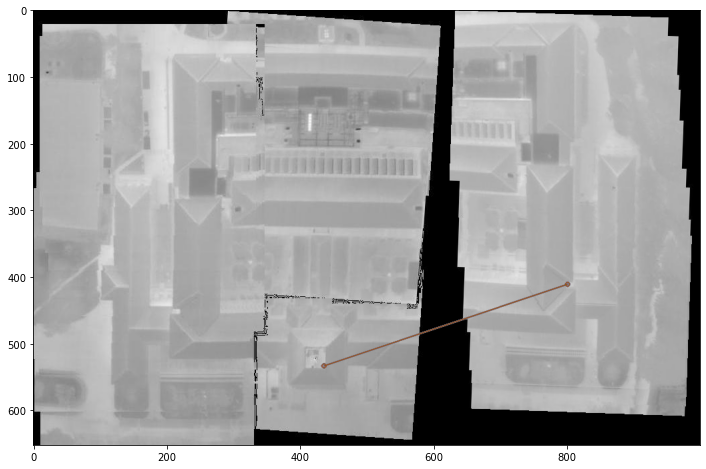

In [19]:
i, j, k = 'p2', ks[4], 'p3'
rot = -2
margins = [400,500,500,600]#[500, 550, 400, 450]
tempfiles = ['lib_strips/'+str(i)+'.jpg','lib_strips/'+str(j)+'.jpg']

feature_extractor, feature_matching = 'orb', 'bf'
arrs = [hf.img_to_arr(tempfiles[0], xq=xq, yq=yq), hf.img_to_arr(tempfiles[1], xq=xq, yq=yq)]
trainImg, queryImg = [imageio.imread(i) for i in tempfiles]
queryImg = np.ma.masked_where(ndimage.rotate(queryImg, rot)<1e-2, ndimage.rotate(queryImg, rot))

trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]
kpsA, featuresA = st.detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = st.detectAndDescribe(queryImg_gray, method=feature_extractor)
matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
fig = plt.figure(figsize=(20,8))
if feature_matching == 'bf':
    matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
elif feature_matching == 'knn':
    matches = st.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
matchesUsed = list(compress(matches,[kpsA[i.queryIdx].pt[0] > margins[0]
                                     and kpsA[i.queryIdx].pt[0] < margins[1]
                                     and kpsA[i.queryIdx].pt[1] > margins[2]
                                     and kpsA[i.queryIdx].pt[1] < margins[3]
                                     for i in matches]))
img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matchesUsed,100),
                       None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

Stitch lines according to matches and an "add" adjustment of pixels.

In [20]:
# Library
# 1 to 2 [-10,]
# 2 to 3 [8,40]
# 3 to 4 [210,-75]

Filt. matches: 1, stdev: 0.0
[47, 656, 456, 844]
(605, 155, 3)
(605, 155, 3)
Images 0 and 1 merged.


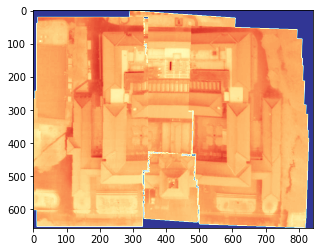

In [23]:
adds = [210,-75]
# Potential to improve by filtering out matches that are not in same direction of travel as drone
ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matchesUsed]])
mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matchesUsed]])
diff = np.median(ma-mb, axis=0).astype(int)+adds#+[50,-140]
totalBox=[trainImg.shape[0], trainImg.shape[1]]
prevBox=[0,trainImg.shape[0],0,trainImg.shape[1]]
prevImg = np.ma.masked_where(trainImg < 1e-1, trainImg)

totalBox, prevNew, prevImg, prevBox = st.stitch_img_result_pano(ma, mb, diff, totalBox, prevBox, arrs, prevImg, prevNum=0, imgNum=1,
                      min_matches=0, max_stdev=20, tmin=-10, tmax=40, verbose=True, rgb_query=queryImg, inv=False)

plt.imshow(prevImg.mean(axis=2),cmap=cmap)
single = prevImg.mean(axis=2).astype(np.uint8)
imageio.imwrite('lib_strips/'+k+'.jpg',np.dstack((single,single,single)))   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


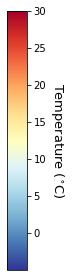

In [295]:
# Save as .kmz file
result = np.ma.masked_where(np.dstack((single,single,single))==0, np.dstack((single,single,single)))
extent = [] # Auto get coords from idf
inputCoords = np.array([[0.106800, 0.108980],[52.204215, 52.205880]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, first = pl.plot_kml(result.data, conv, outName+'_stitch', 1024*10, rot=90, temp=False, tmin=tmin, tmax=tmax)
_, ds = pl.plot_kml(hf.downsample_arr(first,pxSize,resolution), conv, outName+'_ds_stitch', 1024*10, rot=0, scale=first)
pl.plot_kml_legend(cs, outName+'_stitchlegend')
pl.plot_kml_path(idf, conv, outName+'_stitchpath', 1024*10)
pl.make_kml(conv, figs=[outName+'_stitch.png', outName+'_ds_stitch.png', outName+'_stitchpath.png'], 
            colorbar=outName+'_stitchlegend.png', kmzfile=outName+'stitch_thermal.kmz',
            description=str(round(pxSize,2))+'m resolution thermal imagery', name='Drone resolution')

In [296]:
save_to_csv(first, ds, conv, pxSize, resolution, outName+'_stitch', single=True)

In [291]:
# Save as .csv file
def save_to_csv(arr1, arr2, conv, res1, res2, name, single=False):
    arr_s = arr1.shape
    ptslon = np.linspace(conv[0].min(),conv[0].max(),arr_s[1]+1)[:-1]
    ptslon += (ptslon[1]-ptslon[0])/2
    ptslat = np.linspace(conv[1].min(),conv[1].max(),arr_s[0]+1)[:-1]
    ptslat += (ptslat[1]-ptslat[0])/2
    lonm, latm = np.meshgrid(ptslon,ptslat)
    if single: tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), arr1.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', str(round(res1,2))+'m T(C)'])
    else:
        ds_q = int(np.floor(res1/res2))
        if ds_q>1:
            arr_mod = np.round(arr2[:-(arr2.shape[0] % ds_q),:-(arr2.shape[1] % ds_q)]).astype(int)
            most=np.zeros([len(range(0,arr_mod.shape[0]-ds_q,ds_q))+1, len(range(0,arr_mod.shape[1]-ds_q,ds_q))+1])
            for i in range(0,arr_mod.shape[0],ds_q):
                for j in range(0,arr_mod.shape[1],ds_q):
                    most[int(i/ds_q),int(j/ds_q)] = Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
        else:
            ds_q = int(np.floor(res2/res1))
            arr_mod = np.round(arr1[:-(arr1.shape[0] % ds_q),:-(arr1.shape[1] % ds_q)]).astype(int)
            most=np.zeros([arr1.shape[0], arr1.shape[1]])
            for i in range(0,arr_mod.shape[0],ds_q):
                for j in range(0,arr_mod.shape[1],ds_q):
                    #print(Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0])
                    ct = Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
                    most[int(i/ds_q):int(i/ds_q)+ds_q,int(j/ds_q):int(j/ds_q)+ds_q] = np.array([[ct for y in range(ds_q)] for x in range(ds_q)]) if ct is None else np.array([[ct for y in range(ds_q)] for x in range(ds_q)]).astype(int)

        tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), arr1.reshape(-1,1), most.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', str(round(res1,2))+'m T(C)', str(round(res2, 2))+'m T(C)'])
    filt = tdf[arr1.mask.reshape(-1,1) == False]
    filt.to_csv(name+'.csv', index_label='UID')